<a href="https://colab.research.google.com/github/yontodd/nonfarm_payrolls/blob/main/payrolls_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
# Data libraries
import pandas_datareader as pdr
import datetime
import time
from datetime import date
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ML model libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Pull economic data

In [ ]:
# Set the start and end dates for your data
# End date set for today, so will pull all data up to latest releases

start_date = datetime.datetime(1992, 1, 1)
end_date = date.today()

# Or if you want to end on specific date
#end_date = datetime.datetime(2020,1,1)

# Define the FRED indicator codes you want to fetch.
indicators = ['PAYEMS','UNRATE',"LNS12300060",'CPIAUCNS',"PPIACO","FEDFUNDS","UMCSENT","BUSINV","RSXFS"]

# Fetch the data from FRED
data = pdr.get_data_fred(indicators, start_date, end_date)

# Fetch daily data for the yield curve
yield_curve_data = pdr.get_data_fred('T10Y2YM', start_date, end_date)

# Resample the daily yield curve data to monthly, using the mean as aggregation
yield_curve_data_monthly = yield_curve_data['T10Y2YM'].resample('MS').first()

# Merge the monthly yield curve data with the main DataFrame
data = data.merge(yield_curve_data_monthly, left_index=True, right_index=True, how='left')

In [ ]:
# Display the first few rows of the DataFrame
print(data.tail())

            PAYEMS  UNRATE  LNS12300060  CPIAUCNS   PPIACO  FEDFUNDS  UMCSENT  \
DATE                                                                            
2023-07-01  156311     3.5         80.9   305.691  253.835      5.12     71.5   
2023-08-01  156476     3.8         80.9   307.026  257.674      5.33     69.4   
2023-09-01  156738     3.8         80.8   307.789  258.797      5.33     67.9   
2023-10-01  156888     3.9         80.6   307.671  255.033      5.33     63.8   
2023-11-01  157087     3.7         80.7   307.051  253.811      5.33      NaN   

               BUSINV     RSXFS  T10Y2YM  
DATE                                      
2023-07-01  2539181.0  603792.0    -0.93  
2023-08-01  2548843.0  608386.0    -0.73  
2023-09-01  2553086.0  612633.0    -0.64  
2023-10-01  2550016.0  610564.0    -0.27  
2023-11-01        NaN  610995.0    -0.38  


In [ ]:
# Adjust the dataset for m/m changes for some of the variables

timeframe = 1 # m/m change

for col in data.columns:
  data[col] = data[col].diff(timeframe)

# Drop rows with NaNs
data.dropna(inplace=True)

In [ ]:
data.head()

,PAYEMS,UNRATE,LNS12300060,CPIAUCNS,PPIACO,FEDFUNDS,UMCSENT,BUSINV,RSXFS,T10Y2YM
DATE,,,,,,,,,,
1992-02-01,-54.0,0.1,-0.2,0.5,0.4,0.03,1.3,1308.0,298.0,0.06
1992-03-01,47.0,0.0,0.0,0.7,0.1,-0.08,7.2,3125.0,-418.0,-0.28
1992-04-01,155.0,0.0,0.2,0.2,0.2,-0.25,1.2,2728.0,1227.0,0.29
1992-05-01,133.0,0.2,0.0,0.2,0.9,0.09,2.0,-437.0,978.0,0.02
1992-06-01,69.0,0.2,0.1,0.5,0.8,-0.06,1.2,5431.0,790.0,0.05


In [ ]:
# Shift all data except PAYEMS back a month
data_shifted = data.shift(periods=1).drop(columns=["PAYEMS"], axis=1)
data_shifted.dropna(inplace = True)

In [ ]:
# Merge original change in payrolls with shifted dataset
data_shifted = data_shifted.merge(data[["PAYEMS"]],left_index=True, right_index=True, how='left')


In [ ]:
data_shifted

,UNRATE,LNS12300060,CPIAUCNS,PPIACO,FEDFUNDS,UMCSENT,BUSINV,RSXFS,T10Y2YM,PAYEMS
DATE,,,,,,,,,,
1992-03-01,0.1,-0.2,0.500,0.400,0.03,1.3,1308.0,298.0,0.06,47.0
1992-04-01,0.0,0.0,0.700,0.100,-0.08,7.2,3125.0,-418.0,-0.28,155.0
1992-05-01,0.0,0.2,0.200,0.200,-0.25,1.2,2728.0,1227.0,0.29,133.0
1992-06-01,0.2,0.0,0.200,0.900,0.09,2.0,-437.0,978.0,0.02,69.0
1992-07-01,0.2,0.1,0.500,0.800,-0.06,1.2,5431.0,790.0,0.05,82.0
...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.3,-0.1,0.764,-3.238,0.23,-4.7,-1129.0,3149.0,0.00,105.0
2023-07-01,-0.1,0.2,0.982,0.190,0.02,5.2,-3620.0,778.0,-0.33,236.0
2023-08-01,-0.1,0.0,0.582,-0.025,0.04,7.3,1974.0,3056.0,-0.04,165.0


<Axes: >

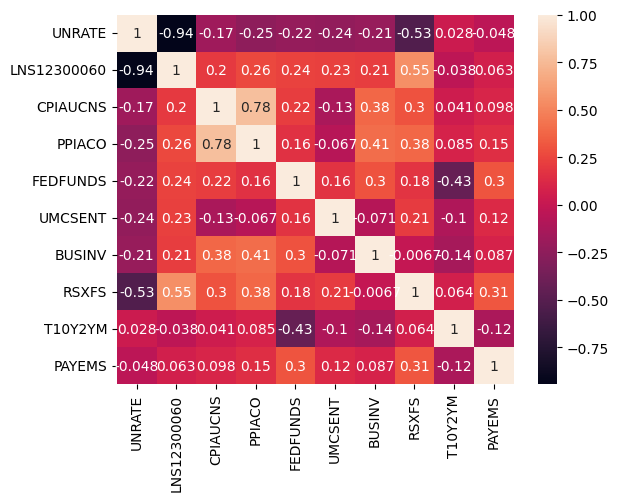

In [ ]:
corr = data_shifted.corr()
sns.heatmap(corr,annot=True)